In [48]:
from google.colab import files
from IPython.display import Image
upload = files.upload()

Saving result.png to result.png


**Lambda Layer**: allow coder to write an arbitrary piece of code as a layer in the neural network

For example, scaling your data with an explicit pre-processing step and feed that data into neural network, you can instead have a Lambda layer. 

Basically a **lambda function**, an unnamed function is to implement as a layer in neural network that resend the data, scale it. Now that **pre-processing step is no longer a separate and distinct step is part of neural network**. 

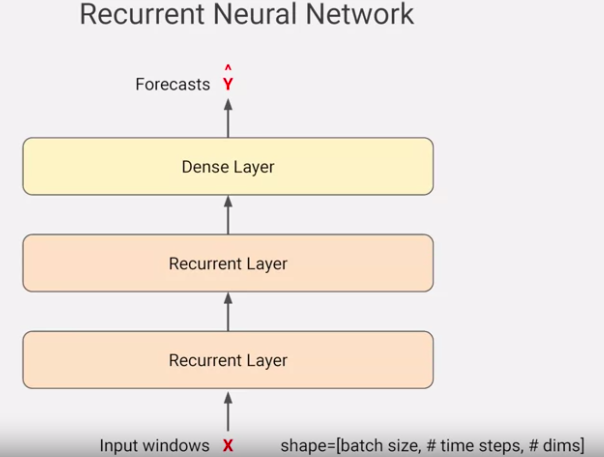

In [3]:
Image('rnn.png', width = 600)

## RNN

RNN is recurent neural network that contains current layer. This designed a sequential **process sequence of inputs**. RNN are flexible and able to process  all kinds of sequences which could be used for predicting text

With RNN, you can **feed in batches of sequences and output batches of forecast**. 

## Shape of inputs to RNN

$$Shape = [batch size, #time steps, #dim of each time step ]$$

For example if it is a univariate time series, #dim = 1

Below picture, it looks like many cells, actually only **1 cell** which used repeatedly. 

In the picture, window size = 30, if batch them into 4. The shape will be $[4, 30 , 1]$. At each time step, **memory cell input will be 4x1 matrix**

The memory cell(图中Mem Cell) aslo take input of state matrix from previous step. In the first step, state matrix is 0. For the sequent one, will be the output from memory cell. But other than state vector, **cell aslo output Y value**. If memory cell comprise 3 neurons. Then output matrix will be 4x3(number of neuron). 因此下图output dimension will be 4x3x30. 4 is batch size, 3 is 3 neurons. 30 is number of steps. In a simple RNN, **the state output H is just copy of Y**, so $H_0 = \hat Y_0, H_1 = \hat Y_1$. At each time step, **the memory cell get both current input and previous out**




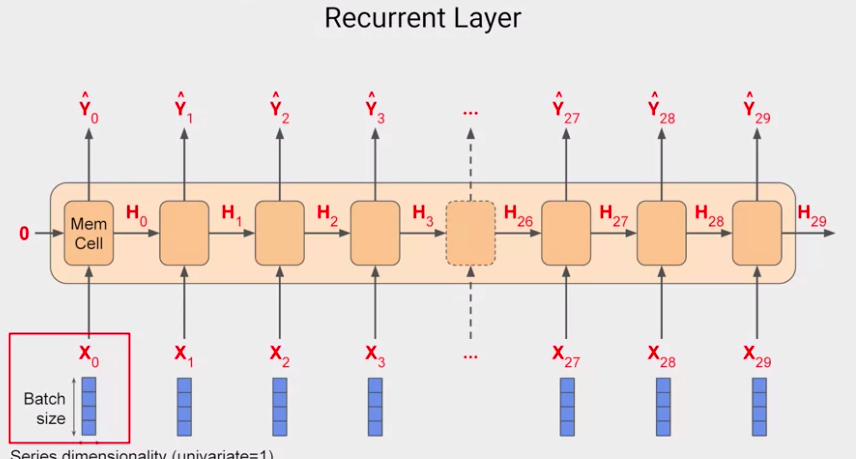

In [15]:
Image('rnn4.png', width = 600)

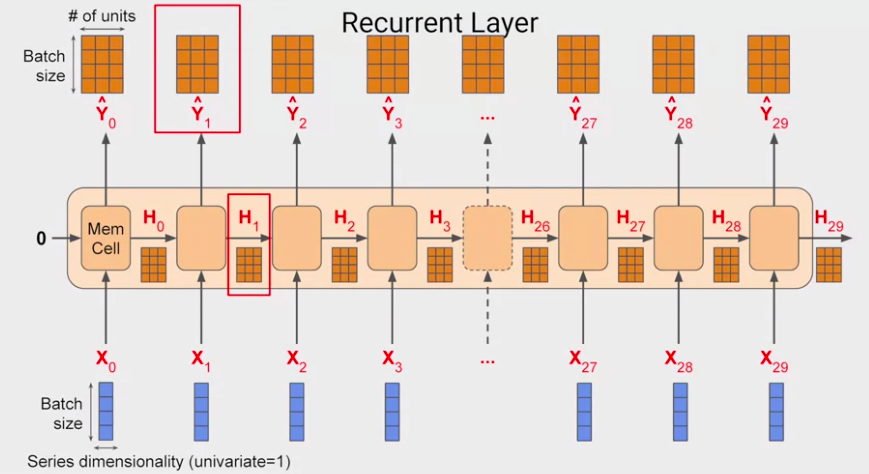

In [18]:
Image('rnn5.png', width = 600)

## Sequence to Vector RNN

Sometime, want to input sequence and don't want to output a sequence. Instead you just get a single vector for each instance in the batch. **Ignore all the output except the last one**. When implement keras in Tensorflow, this is default behavior. If want recurrent layer to output a sequence, **has to specify return_sequence = True. Must do it if stack one RNN on top of another**.

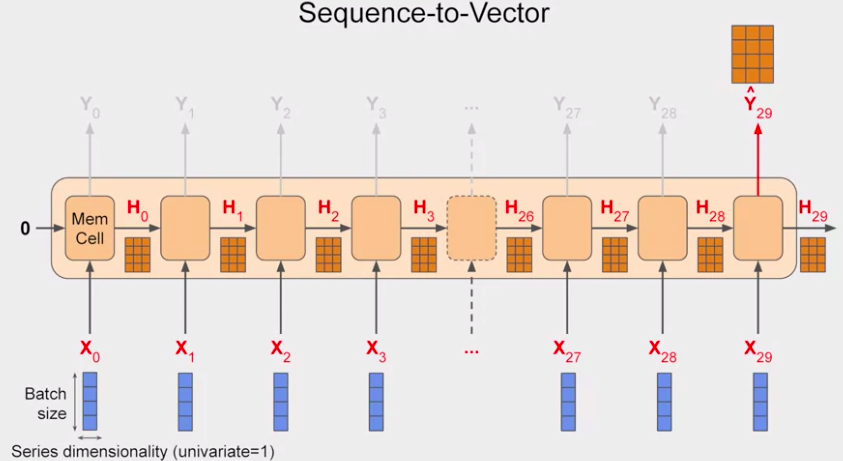

In [21]:
Image('屏幕快照 2019-10-16 下午8.43.41.png', width = 600)

## Sequence to Sequence RNN

It input batches of sequences and return batches of sequences of the **same length**. The dimensionality **may not always match**. **It depends on the number of units in memory cell**.


Below code, note input_shape is $[None, 1]$. **Tensorflow assume the first dimension is batch size. And that can be any size so you don't need to define it**. Next dimension is #time step which set to None, **meaning RNN can handle sequence of any length**. Last dimension = 1, because we use **univariate time step**. 

Second SimpleRNN return_sequence = True in all recurrent layer. Then it will all output sequences then Dense layer will get it as input. Keras handle this by using **the same dense layer** independently at each time step. 下面图看起来像多个Dense layer, but it is **the same one reused at each time step**. 





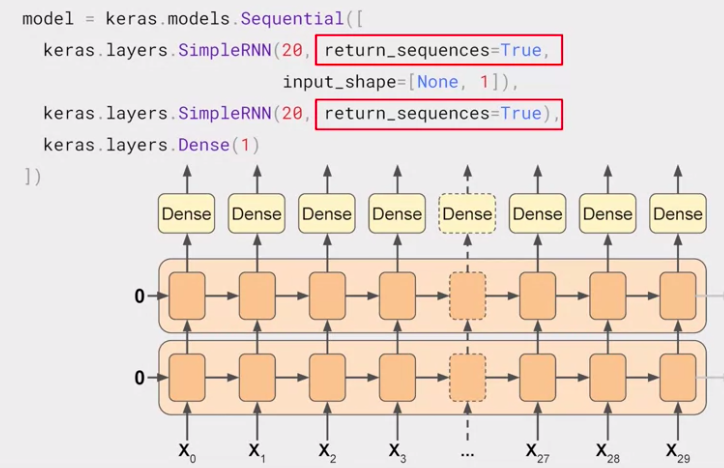

In [24]:
Image('屏幕快照 2019-10-16 下午8.53.48.png', width = 600)

## Lambda Layer

This layer allow us to perform arbitrary operations to expand the functionality of Tensorflow Keras

下图: 

1. keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None])
   - Lambda layer helped with dimensionality. RNN 3 dimension $[batch_size, #time step, # series dimensionality]$. With lambda layer, we can fit it, without rewrite window_dataset helper function(last week material). **Using lambda, we just expand our array by 1 dimension**, by setting input shape to None, we're saying that model can take sequence of any length
2. keras.layers.Lambda(lambda x: x * 100.0)
  - If we scale the input by 100, can help training. The default RNN function is tanh, The output is between $[-1,1]$. Since time series in that order are usually like 10, 40, 50... Scale the output to the same ballpark can help learning. 

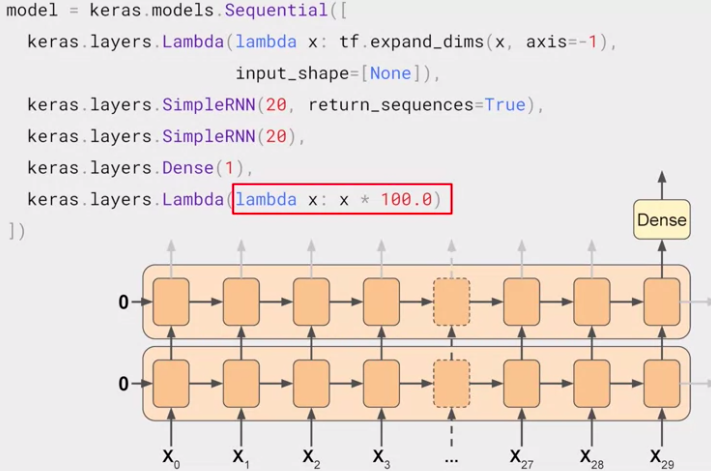

In [27]:
Image('屏幕快照 2019-10-16 下午9.10.08.png', width = 600)

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size = 128, 
                            shuffle_buffer = shuffle_buffer_size)

model = tf.keras.model.Sequential([
     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis =-1), input_shape = [None]),
     tf.keras.layers.SimpleRNN(40, return_sequences = True), 
     tf.keras.layers.SimpleRNN(40),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x: x * 100.0)                              
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

optimizer = tf.keras.optmizer.SGD(lr = 1e-8, momentum=0.9)

#https://en.wikipedia.org/wiki/Huber_loss
# Huber function is less sensitive to outliers, maybe a little bit noise
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

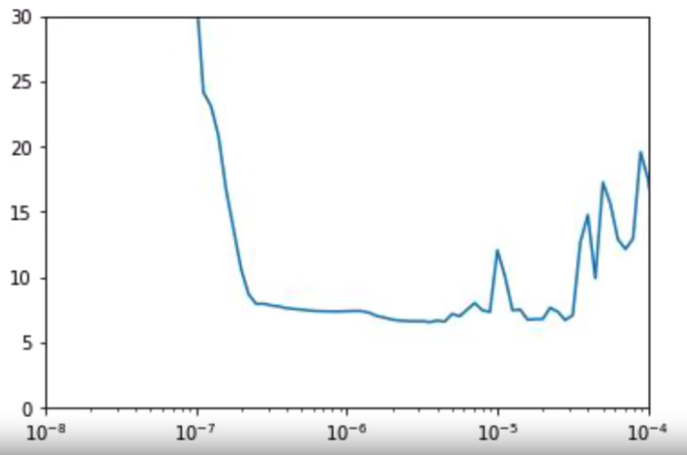

In [31]:
#After plot learning rate VS loss, find learning rate = 5e-5
Image('屏幕快照 2019-10-16 下午9.19.52.png', width = 500)

In [ ]:
optimizer = tf.keras.optmizer.SGD(lr = 5e-5, momentum=0.9)
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])
history = model.fit(train_set, epochs = 500)

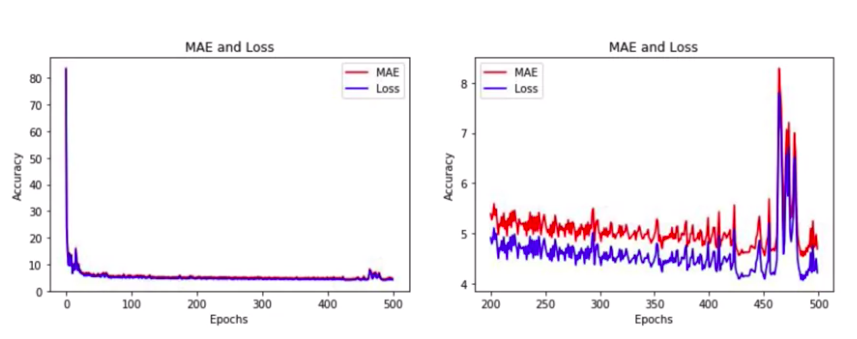

In [35]:
Image('屏幕快照 2019-10-16 下午9.21.30.png', width = 600)
#Here is MAE used for training, and right is the zoom in for last few epoch, so 400 may be a good training epoch

## LSTM

For RNN, they have cells that took batches as input or X, and calculate a output Y as well as state vector that fed into the cell along the next X which then resulted in Y and state vector. State is a factor in subsequent calculations. **Problem is its impact can diminish greatly over timestamps**. LSTM is to add a **cell state to it and keep a state through the life of training so that state is passed from cell to cell**. **It means that data in LSTM on eariler in the window can have a greater impact on overall projection than in case of RNN**. The state can also be **bidirection**, which can be forward or backward. 

**LSTM apply text well but for numeric sequences may not be**

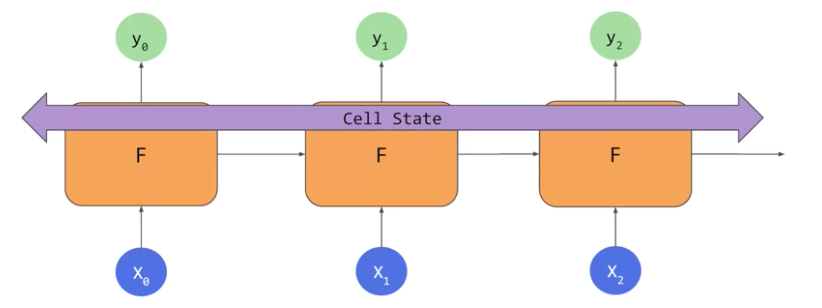

In [38]:
Image('屏幕快照 2019-10-16 下午9.26.37.png', width = 600)

In [ ]:
tf.keras.backend.clear_session() #this clear any interal variables, earlier version not affect later version of model
train_set = windowed_dataset(x_train, window_size, batch_size = batch_size, 
                            shuffle_buffer = shuffle_buffer_size)

model = tf.keras.model.Sequential([
     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis =-1), input_shape = [None]),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x: x * 100.0)                              
])

model.compile(loss ='mse', optimizer = tf.keras.optimizer.SGD(lr=1e-6, momentum = 0.9))
history = model.fit(train_set, epochs = 100, verbose - 0)

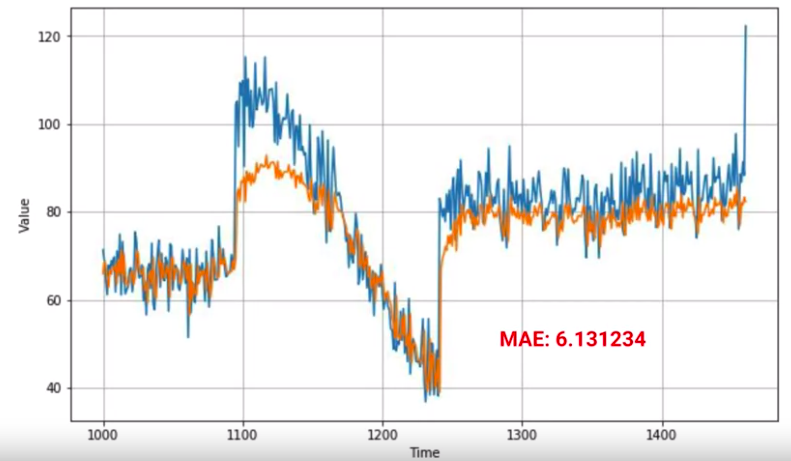

In [41]:
Image('屏幕快照 2019-10-16 下午9.39.30.png', width = 600)
# MAE not bad and not great, better than above model without LSTM

Add another LSTM in the code



In [ ]:
model = tf.keras.model.Sequential([
     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis =-1), input_shape = [None]),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequence = True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x: x * 100.0)                              
])
model.compile(loss ='mse', optimizer = tf.keras.optimizer.SGD(lr=1e-6, momentum = 0.9))
history = model.fit(train_set, epochs = 100, verbose - 0)

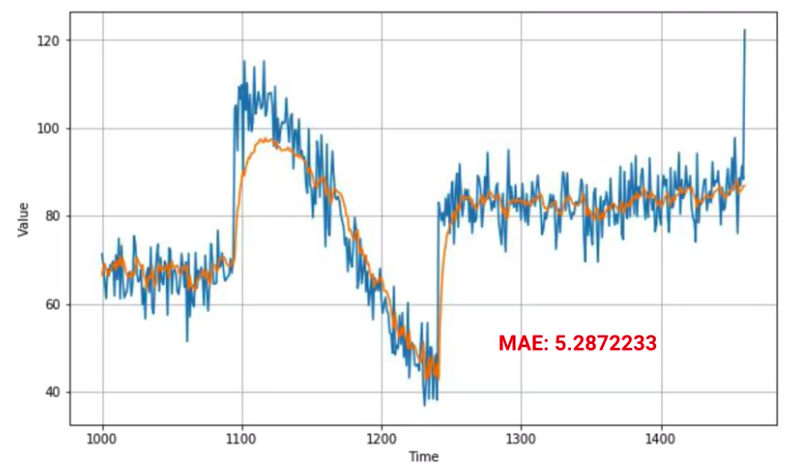

In [44]:
Image('屏幕快照 2019-10-16 下午9.41.16.png', width = 600)
#Now it track much better and closer to original data. It gives mean average error that's a lot better and show we are heading right direction

If add third LSTM in the code

In [ ]:
model = tf.keras.model.Sequential([
     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis =-1), input_shape = [None]),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequence = True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequence = True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x: x * 100.0)                              
])
model.compile(loss ='mse', optimizer = tf.keras.optimizer.SGD(lr=1e-6, momentum = 0.9))
history = model.fit(train_set, epochs = 100, verbose - 0)

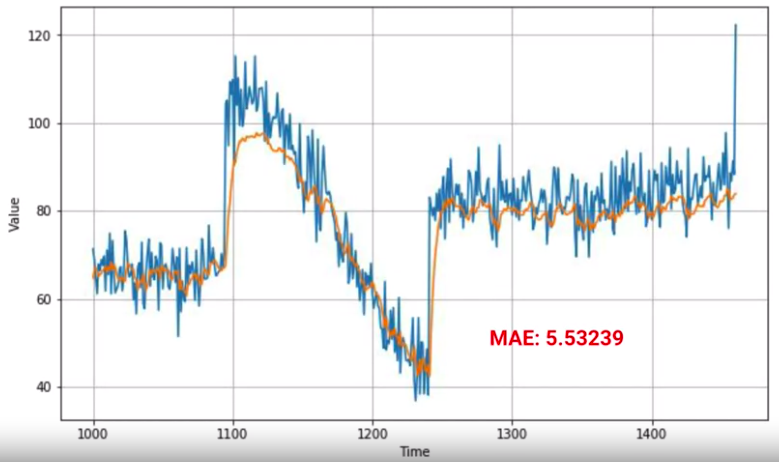

In [49]:
Image('result.png', width = 600)
#Nothing much difference compared to 2 LSTM layer and MAE go down